# Sentiment Analysis and Prediction in Python

Welcome to your webinar workspace! Here, you can follow along as we try to predict the sentiment of movie reviews!

To consult the solution, head over to the file browser and select `notebook-solution.ipynb`.

The cells below install a package currently unavailable in Workspace and import the libraries we will use in this code. The final cell also imports the data in your directory (`"movie_reviews.csv"`).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movie-review-sentanlsys/movie_reviews.csv


In [2]:
%%capture
!pip install wordcloud

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import tensorflow as tf


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
import re
import nltk
from nltk.corpus import stopwords

# Load data as a DataFrame
df = pd.read_csv("/kaggle/input/movie-review-sentanlsys/movie_reviews.csv")

# Preview the data
df.head()

2025-05-18 19:56:01.505575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747598161.723555      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747598161.785608      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,text,label
0,"This is a really bad film, with bad acting and...",0
1,MAJOR LEAGUE: BACK TO THE MINORS (1998) ½* St...,0
2,Gender Bender sexes things up a bit for the x-...,1
3,Several things become apparent after the first...,0
4,I really enjoyed this -- I'm a big fan of movi...,1


In [4]:
EMBEDDING_LEN = 32  # The length of the word embedding vector
VOCAB_SIZE = 5000

NUM_SAMPLES = 1000

BUFFER_SIZE = 10000
BATCH_SIZE = 64

UNITS = 64

## Inspect and explore our data
We can inspect the data types and the number of non-null rows per column using the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method.

In [5]:
# Inspect the data types and non-null rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


As this is a classification problem, we will want to inspect the balance of our target variable `label`. We can use [`.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) with `normalize` set to `True` to return the proportion of each class label.

In [6]:
# Check the value counts of the sentiment label
df['label'].value_counts(normalize=True)

label
0    0.5085
1    0.4915
Name: proportion, dtype: float64

One way to inspect our text data is to create a word cloud, which shows the most frequent words by size. To create one, we initialize a [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). Specifying the stopwords allows us to filter out generic words such as "the" and "and".

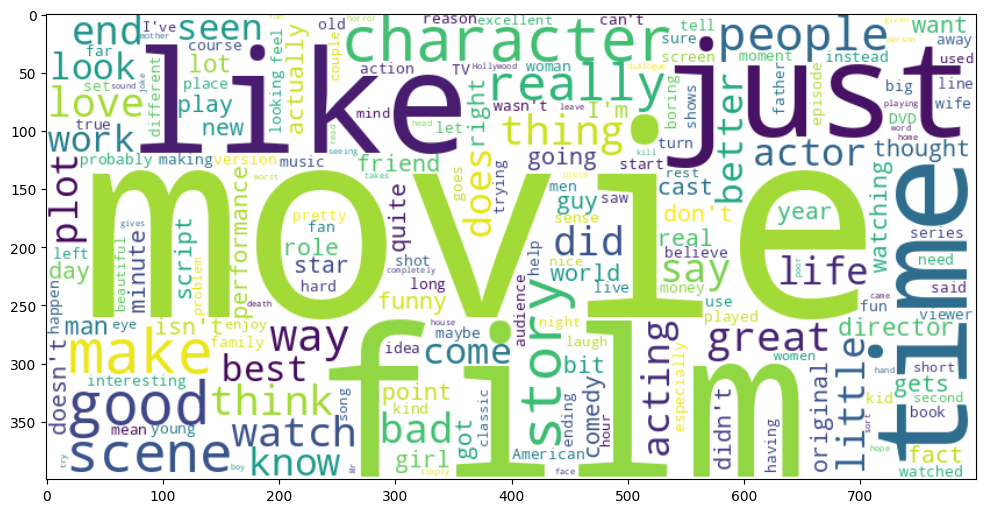

In [7]:
# Concatenate the text review data
reviews = " ".join(df['text'])

# Create the word cloud image
word_cloud = WordCloud(background_color="white",
                      stopwords=ENGLISH_STOP_WORDS,
                       width=800,
                       height=400
                      )


# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display the word cloud
plt.rcParams["figure.figsize"] = (12,8)
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

## Pre-processing the review text
To pre-process the text, we will use the term frequency-inverse document frequency, or TfIdf. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents).
TfIdf has the advantages of:

- Highlighting words that are common within a document but not across documents.
- Returning low scores for words common across all reviews (e.g., movie in movie reviews).
- Penalizing frequent words so we don't need to worry about stop words as much.

Fortunately, Scikit-Learn has a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class that can convert text data into a set of TfIdf features.

In [8]:
def parse_text(text):
    # 1. Remove all non-letter characters
    text = re.sub("[^a-zA-Z]", ' ', text)
    # 2. Convert to lowercase and split into words
    text = text.lower().split()
    # 3. Remove stopwords
    swords = set(stopwords.words("english"))
    text = [w for w in text if w not in swords]
    # 4. Join the list of words back into a string
    text = " ".join(text)

    return text


In [9]:
df["text"] = df['text'].apply(lambda x: parse_text(x))

In [10]:
target = df['label']
text = df['text']
dataset = tf.data.Dataset.from_tensor_slices((df['text'].values, df['label'].values))

2025-05-18 19:56:19.829191: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
len(dataset)

4000

In [12]:
dataset.as_numpy_iterator().next()

(b'really bad film bad acting boring pace lorenzo lamas really cool though characters annoying except lamas absolutely one root care plus action boring film gives us villains supposed find menacing disturbing fact boring laughable bunch morons wanted shut plus looks cheap amateurish lorenzo lamas lot charisma save piece crap believe opening really cool ending however middle incredibly boring got urge press fast forward button plus dialog especially laughable cool bar scene really liked lamas heads dock falls apart plus scene villains torture jennifer family kills supposed find disturbing fact laughable really bad film bad acting boring pace lorenzo lamas really cool though however enough recommended direction bad george erschbamer bad job mediocre camera work bland location keeping film boring pace acting pretty bad except lamas lorenzo lamas awesome required act quite fun watch really cool character lot charisma however even save one chemistry cast either lamas rules josie bell terrib

In [13]:
# Split the dataset into validation , test , and train 
train_dataset = dataset

# Take 20% of the train_dataset
test_dataset = train_dataset.shard(5,4)

# Create a new train_dataset dataset
temp_train_dataset = train_dataset.shard(5, 3)
for i in range(3):
    temp_train_dataset = temp_train_dataset.concatenate(train_dataset.shard(5, i))

train_dataset = temp_train_dataset

train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)



# Take the elements at index 9, 19, 29... into the validation dataset
validation_dataset = test_dataset.shard(5, 4)

validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

# Create a new train_dataset dataset. Append the remaining shards of the train_validation_dataset dataset.
temp_test_dataset = test_dataset.shard(5, 3)
for i in range(3):
    temp_test_dataset = temp_test_dataset.concatenate(test_dataset.shard(5, i))

test_dataset = temp_test_dataset

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(50, 3, 10)

## Text encoding


We're taking a different approach with text encoding in this notebook. Rather than having a separate text tokenizer, we'll create an encoder layer as part of the model itself. This allows us to pass text directly into the model without prior encoding.

The encoder still needs fitting, the same as we've done before.

In [15]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)
encoder.adapt(train_dataset.map(lambda text, label_:text))

In [16]:
encoder('new text')

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  70, 2573])>

## Bidirectional LSTM

In [17]:
model_bi = Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Bidirectional(LSTM(UNITS)),
    Dense(64, activation='relu'),
    Dense(1)
]
)

# Compile the model
model_bi.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_bi = model_bi.fit(train_dataset, validation_data=validation_dataset, epochs=5)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.5112 - loss: 1.3334 - val_accuracy: 0.6062 - val_loss: 0.6688
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.7492 - loss: 0.5918 - val_accuracy: 0.7188 - val_loss: 0.5222
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.6872 - loss: 0.6093 - val_accuracy: 0.7563 - val_loss: 0.4720
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - accuracy: 0.9194 - loss: 0.2730 - val_accuracy: 0.7812 - val_loss: 1.1466
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.9548 - loss: 0.1634 - val_accuracy: 0.8250 - val_loss: 0.7713


In [18]:
model_bi.predict(tf.convert_to_tensor(["this is the best film ever", "this is the worst film ever"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


array([[ 0.42908007],
       [-0.09829529]], dtype=float32)

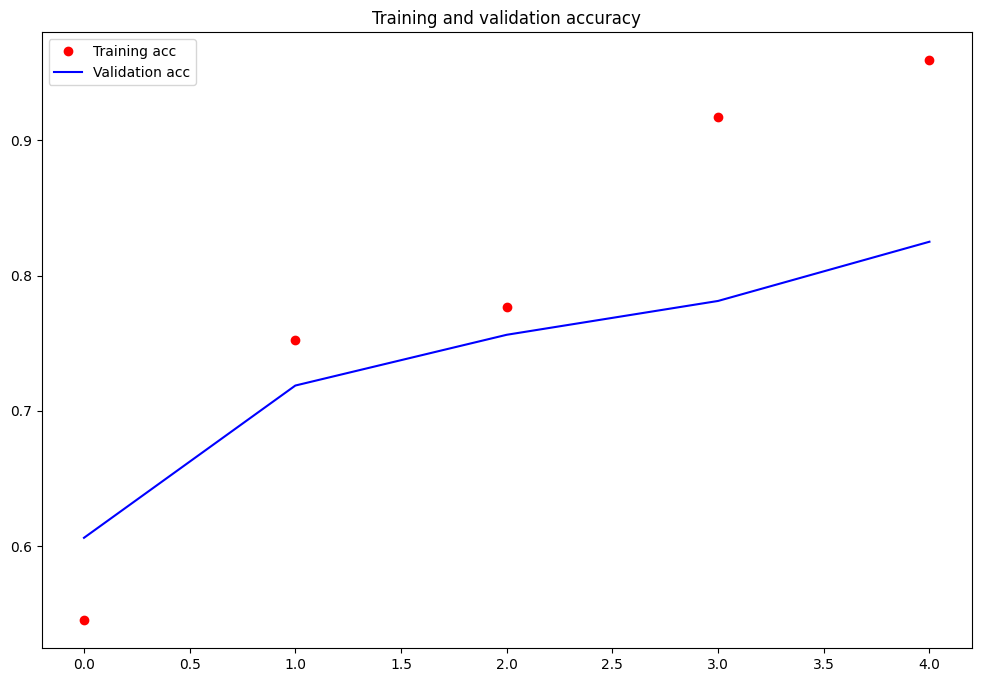

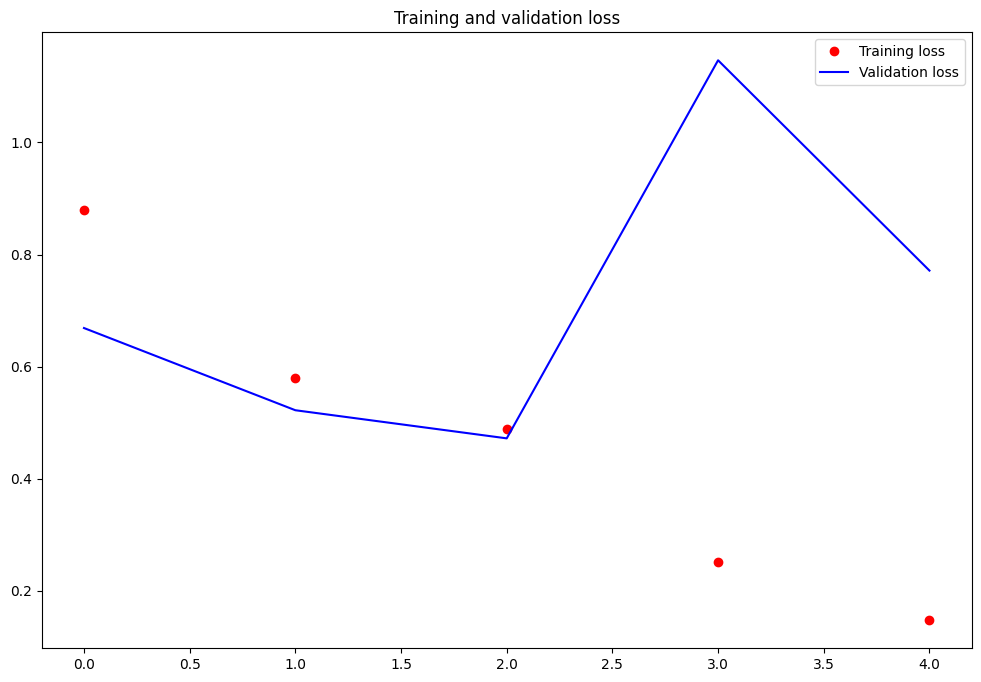

In [19]:
acc = history_bi.history['accuracy']
val_acc = history_bi.history['val_accuracy']
loss = history_bi.history['loss']
val_loss = history_bi.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
print('\nBidirectional LSTM')
score, acc = model_bi.evaluate(validation_dataset)
print('Validation loss:', score)
print('Validation accuracy:', acc)


print('\nBidirectional LSTM')
score, acc = model_bi.evaluate(test_dataset)
print('Test loss:', score)
print('Test accuracy:', acc)


Bidirectional LSTM
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8168 - loss: 0.7403
Validation loss: 0.7713366746902466
Validation accuracy: 0.824999988079071

Bidirectional LSTM
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7897 - loss: 0.8579
Test loss: 0.924129843711853
Test accuracy: 0.7828124761581421


## Different way with Random Forest

In [21]:
#specify the word pattern
pattern = r"[a-zA-Z]+"

#Build the vectorizer and fit the text data
vect = TfidfVectorizer(
    token_pattern=pattern,
    stop_words= 'english',
    ngram_range=(1,2),
    max_features=500
)

vect.fit(df['text'])

#create sparse matrix from the vectorizer
tokenized_features = vect.transform(df["text"])

# create a DataFrame of the new features
features = pd.DataFrame(data=tokenized_features.toarray(),
                       columns=vect.get_feature_names_out())
features

,able,absolutely,act,acting,action,actor,actors,actress,actually,add,...,worth,writer,writing,written,wrong,year,year old,years,yes,young
0,0.000000,0.076903,0.080972,0.146118,0.064879,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.086111,...,0.068984,0.0,0.0,0.158718,0.0,0.0,0.0,0.059820,0.080767,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.110679,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173420,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.147773,0.000000,0.149240,0.000000,0.000000,0.000000,0.104017,0.0,0.214473,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117883,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.121085,0.000000,0.0
3996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3998,0.000000,0.000000,0.000000,0.224486,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


Let's add a few more features about the nature of the review, calculating different length metrics for the text (inspired by this [great article](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d)).

In [22]:
# Generate a number of different length metrics based on the text
df["char_count"] = df["text"].str.count(r"\S")
df["word_count"] = df['text'].str.count(pattern)
df["avg_word_length"] = df["char_count"] / df["word_count"]

# Preview our new columns
df.sample(3)

,text,label,char_count,word_count,avg_word_length
3695,watched film along every adaptation could get ...,0,490,81,6.049383
3317,back dvd movie raves chey quentin tarantino ch...,0,856,132,6.484848
2453,let start saying expecting subtle humour wrong...,1,1267,227,5.581498


## Fit a model and evaluate its performance
Finally, we assign our features and target to `X` and `y`, respectively, split our data into train and test subsets, and fit a classification model to the data.

In this case, we use a simple [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and calculate the classification metrics using the test set and our predicted values.

In [23]:
# Define X and y
X = pd.concat([features, df.loc[:, "char_count":]], axis=1)
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

# Train a random forest classifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
# Predict the labels
y_pred = rf.predict(X_test)
# Print classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       523
           1       0.77      0.81      0.79       477

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [24]:
X

,able,absolutely,act,acting,action,actor,actors,actress,actually,add,...,written,wrong,year,year old,years,yes,young,char_count,word_count,avg_word_length
0,0.000000,0.076903,0.080972,0.146118,0.064879,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1023,180,5.683333
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.086111,...,0.158718,0.0,0.0,0.0,0.059820,0.080767,0.0,1719,298,5.768456
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.110679,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,543,91,5.967033
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173420,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,334,57,5.859649
4,0.147773,0.000000,0.149240,0.000000,0.000000,0.000000,0.104017,0.0,0.214473,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,709,122,5.811475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117883,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.121085,0.000000,0.0,382,80,4.775000
3996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,742,128,5.796875
3997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,540,85,6.352941
3998,0.000000,0.000000,0.000000,0.224486,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,610,101,6.039604


We can also generate a confusion matrix using [`ConfusionMatrixDisplay.from_estimator()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay#sklearn.metrics.ConfusionMatrixDisplay.from_estimator) to gain additional insights into the performance of our classification. This allows us to see what percentage of predictions were true positives, true negatives, false positives, and false negatives.

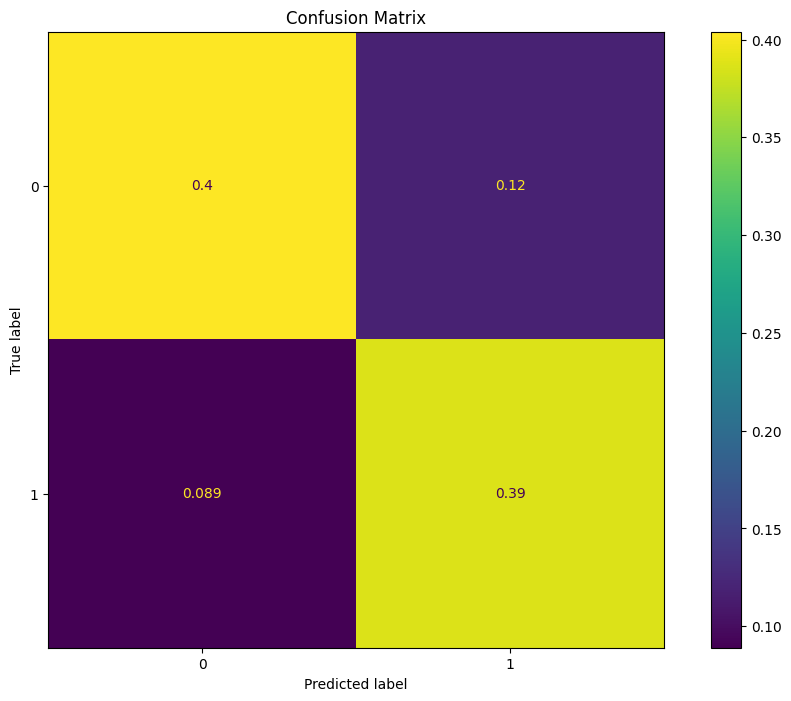

In [25]:
# Print a confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix")
plt.show()

For one final step, let's look at the feature importances to see which words (or features) were most relevant.

In [26]:
# Create a DataFrame of the features and their importances
pd.DataFrame(
    {"feature" : X.columns,  "importance": rf.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
25,bad,0.041513
489,worst,0.029489
171,great,0.021432
23,awful,0.019590
31,best,0.014438
...,...,...
420,taken,0.000441
274,moment,0.000417
269,middle,0.000326
106,editing,0.000309


## Wrapping up
Congratulations! We successfully loaded in some review data, inspected it, performed some simple text-processing, and made predictions.